<a href="https://colab.research.google.com/github/MarshallPotts/CSE450-Machine-Learning/blob/main/Case_study_3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import pandas as pd
!pip install scikit-learn==1.5.2
!pip install contextily
import seaborn as sb
from xgboost import XGBRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import root_mean_squared_log_error
from sklearn.metrics import r2_score
import geopandas as gpd
import matplotlib.pyplot as plt
import numpy as np
import contextily as ctx
from shapely.geometry import Point
from matplotlib import colors

In [ ]:
property_data = pd.read_csv("https://raw.githubusercontent.com/byui-cse/cse450-course/master/data/housing.csv")
property_data.head(100)

,id,date,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,...,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15,price
0,1565930130,20141104T000000,4,3.25,3760,4675,2.0,0,0,3,...,2740,1020,2007,0,98038,47.3862,-122.048,3280,4033,429900.0
1,3279000420,20150115T000000,3,1.75,1460,7800,1.0,0,0,2,...,1040,420,1979,0,98023,47.3035,-122.382,1310,7865,233000.0
2,194000575,20141014T000000,4,1.00,1340,5800,1.5,0,2,3,...,1340,0,1914,0,98116,47.5658,-122.389,1900,5800,455000.0
3,2115510160,20141208T000000,3,1.75,1440,8050,1.0,0,0,3,...,1440,0,1985,0,98023,47.3187,-122.390,1790,7488,258950.0
4,7522500005,20140815T000000,2,1.50,1780,4750,1.0,0,0,4,...,1080,700,1947,0,98117,47.6859,-122.395,1690,5962,555000.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
95,6132600655,20141016T000000,3,2.25,2890,5000,3.0,0,0,3,...,2890,0,2014,0,98117,47.6983,-122.389,2020,5000,930000.0
96,1068000255,20140827T000000,4,3.50,4285,9567,2.0,0,1,5,...,3485,800,1946,0,98199,47.6434,-122.409,2960,6902,1650000.0
97,3052700921,20150211T000000,6,3.00,2620,4350,1.0,0,0,3,...,1760,860,1957,0,98117,47.6780,-122.373,1760,4300,900000.0
98,3024089057,20150106T000000,4,1.00,1170,34925,1.0,0,0,4,...,1170,0,1942,0,98065,47.5305,-121.841,1610,28108,282500.0


In [ ]:
property_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20000 entries, 0 to 19999
Data columns (total 21 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   id             20000 non-null  int64  
 1   date           20000 non-null  object 
 2   bedrooms       20000 non-null  int64  
 3   bathrooms      20000 non-null  float64
 4   sqft_living    20000 non-null  int64  
 5   sqft_lot       20000 non-null  int64  
 6   floors         20000 non-null  float64
 7   waterfront     20000 non-null  int64  
 8   view           20000 non-null  int64  
 9   condition      20000 non-null  int64  
 10  grade          20000 non-null  int64  
 11  sqft_above     20000 non-null  int64  
 12  sqft_basement  20000 non-null  int64  
 13  yr_built       20000 non-null  int64  
 14  yr_renovated   20000 non-null  int64  
 15  zipcode        20000 non-null  int64  
 16  lat            20000 non-null  float64
 17  long           20000 non-null  float64
 18  sqft_l

In [ ]:
#scatterplot of the sqft_living vs sqft_lot
#sb.scatterplot(data=property_data, x=property_data["sqft_living"], y=property_data["sqft_lot"])


In [ ]:
#notice the linear looking grouping around 0 sqft_lot from 0-8000 sqft_living

lot_range = property_data["sqft_lot"].max() - property_data["sqft_lot"].min()
print("lot_range in sqft:", lot_range)

#add feature of acres in each lot
property_data["lot_acres"] = property_data["sqft_lot"] / 43560    #1 acre = 43560sqft
property_data["lot_acres"].describe()
#property_data["lot_acres"].head(20)


lot_range in sqft: 1164274


,lot_acres
count,20000.000000
mean,0.344705
std,0.911418
min,0.011938
25%,0.115702
50%,0.174931
75%,0.245868
max,26.739991


Is there a reason the sqft of the lots is so low? Is there a large difference between the cost of apartments and houses for the same sqft? How do I determine which ones are apartments? number of floors? what about town homes? lot size? Again what about town homes? No basement? How common are multilevel apartments in a large apartment building?

In [ ]:
#find the range of years of these records to figure out any data to add by that time range.
property_data["year"] = property_data["date"].astype(str).str[:4]
property_data["year"] = property_data["year"].astype(int)
year_range = property_data["year"].max() - property_data["year"].min()
year_max = property_data["year"].max()
year_min = property_data["year"].min()
print("year_range: ", year_range)
print("year_max: ", year_max)
print("year_min: ", year_min)


year_range:  1
year_max:  2015
year_min:  2014


In [ ]:
#graph the sqft_lots below 25%
q3 = property_data["sqft_lot"].quantile(0.75)
q1 = property_data["sqft_lot"].quantile(0.25)
print("lower quartile: ", q1)
print("upper quartile: ", q3)
filtered_property = property_data[property_data["sqft_lot"] <= q1]
#sb.scatterplot(data=filtered_property, x=filtered_property["sqft_lot"], y=filtered_property["sqft_basement"])

lower quartile:  5040.0
upper quartile:  10710.0


In [ ]:
#add apartment column need to ad something to filter out houses that don't have
#property_data["apartment"] = (property_data["sqft_basement"] == 0).astype(int)
#property_data["apartment"].head(20)

In [ ]:
#average price column creation
zip_avg_price = property_data.groupby("zipcode")["price"].mean()

#create features for large, medium, and small houses
property_data["large_house"] = (property_data["sqft_living"] > q3).astype(int)
property_data["medium_house"] = ((property_data["sqft_living"] <= q3) & (property_data["sqft_living"] > q1)).astype(int)
property_data["small_house"] = (property_data["sqft_living"] <= q1).astype(int)



In [ ]:


#function for finding the mean of the nearest 15 houses
def find_nearest_neighbors(df, target_lat, target_long):
  distance = df.copy();    #copy the dataframe
  distance["distance"] = np.sqrt((df["lat"] - target_lat)**2 + (df["long"] - target_long)**2)      #create column that stores the distance from the dataframe values to the target
  nearest = distance.nsmallest(15, "distance")    #15 smallest distances away from the target
  return nearest["price"].mean()      #return the mean price value






#column for the price of the 15 nearest houses
property_data["price15"] = property_data.apply(lambda row: find_nearest_neighbors(property_data, row["lat"], row["long"]), axis=1)

#column for the ratio of living sqft to nearest neighbors living sqft
property_data["sqft_neighbor_ratio"] = property_data["sqft_living"] / property_data["sqft_living15"]

#percentage of the living sqft is above ground
property_data["sqft_above_ratio"] = property_data["sqft_above"] / property_data["sqft_living"]

#percent of the living sqft is basement
property_data["sqft_basement_ratio"] = property_data["sqft_basement"] / property_data["sqft_living"]

#grade with living space (bin grade?)

#combine lots of features like: bathrooms, bedrooms, sqft_above, grade, sqft_above, sqft_basement, sqft_livign15, price

In [ ]:
property_data["price15"].head(100)

,price15
0,2.940447e+05
1,2.622667e+05
2,4.470000e+05
3,2.818700e+05
4,5.728701e+05
...,...
95,6.745637e+05
96,1.387833e+06
97,5.882633e+05
98,4.247765e+05


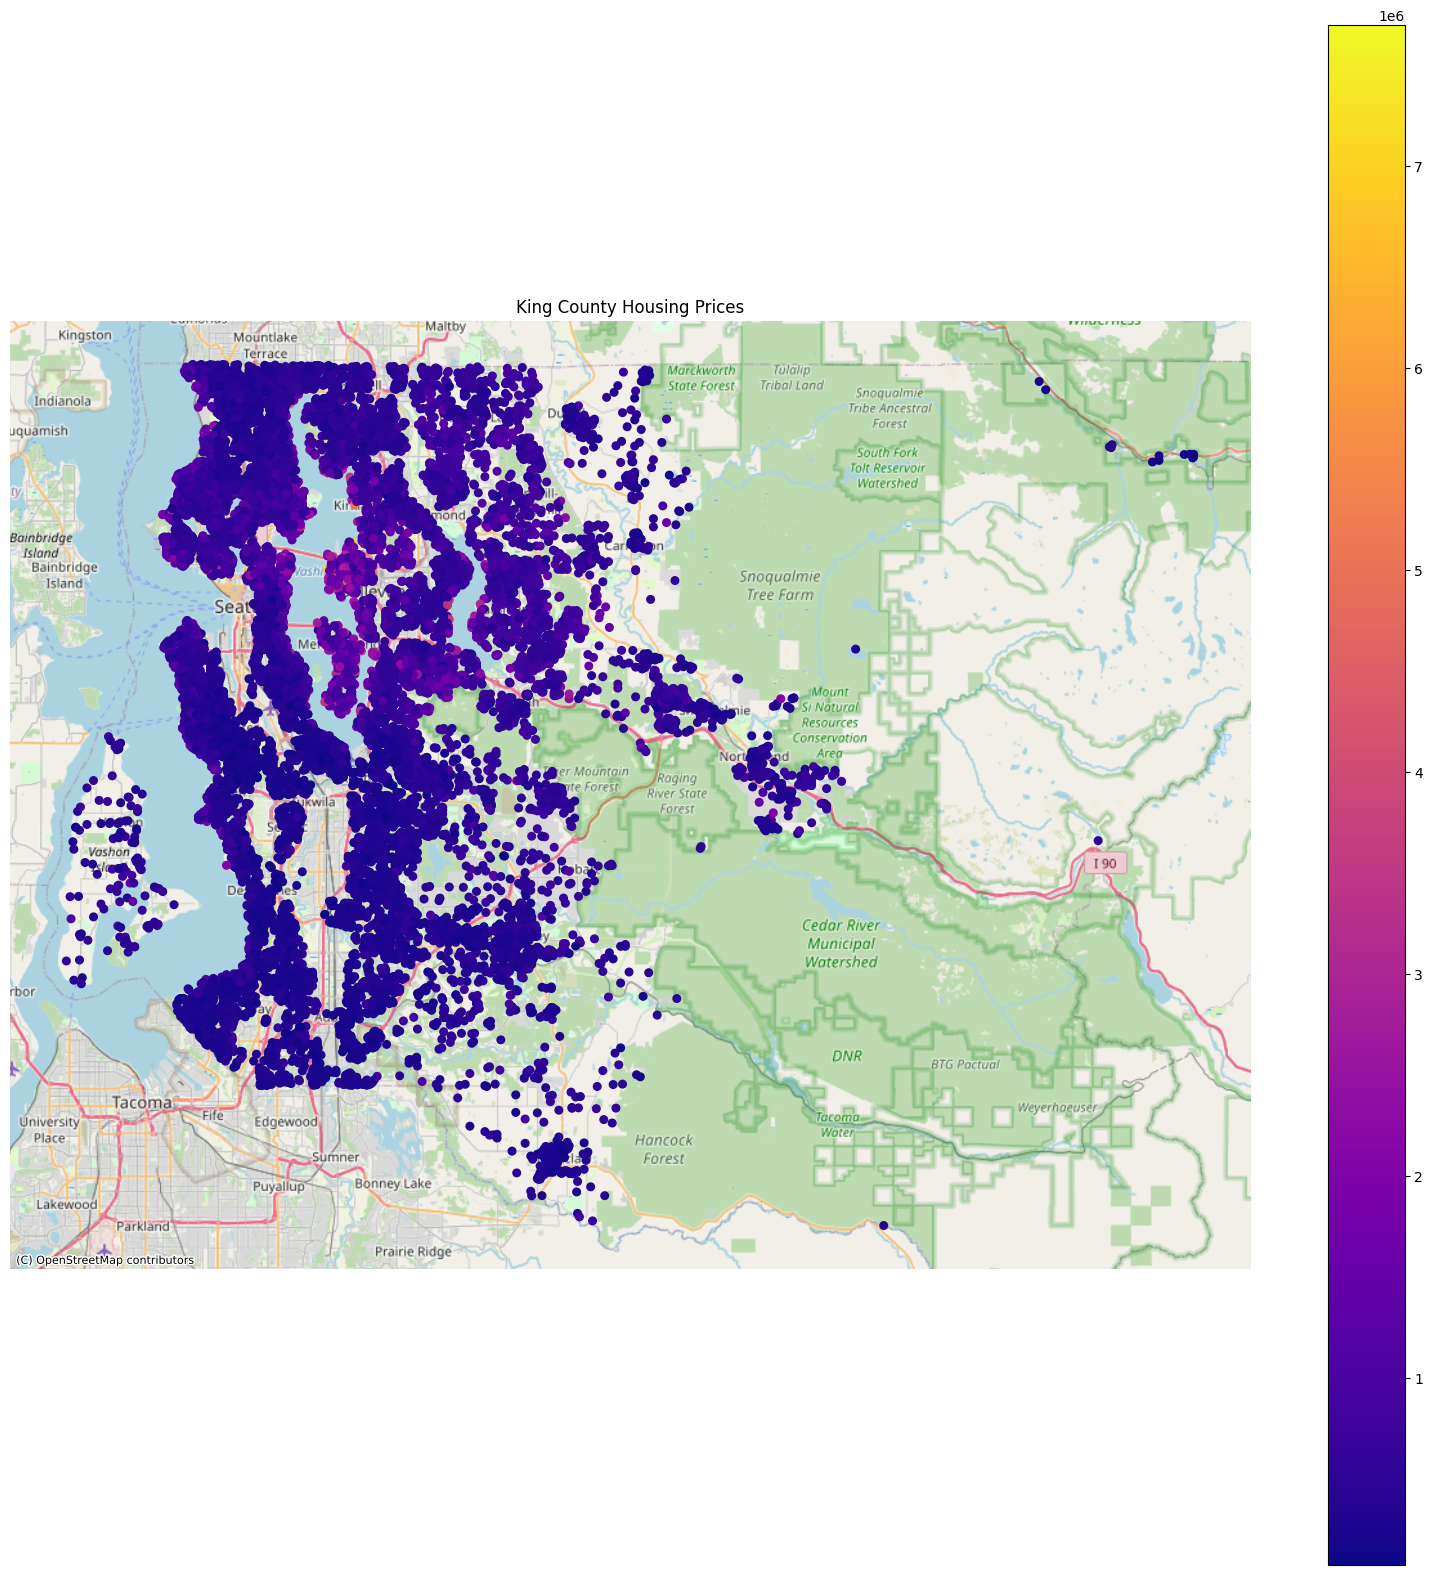

In [ ]:
#map of price to location (lat, long)


geometry = [Point(xy) for xy in zip(property_data['long'], property_data['lat'])]
gproperty_data = gpd.GeoDataFrame(property_data, geometry=geometry, crs="EPSG:4326")

# Convert to Web Mercator (EPSG:3857) for mapping
gproperty_data = gproperty_data.to_crs(epsg=3857)


# Plot with color mapped to price
norm = colors.Normalize(vmin=gproperty_data['price'].min(), vmax=gproperty_data['price'].max())
fig, ax = plt.subplots(figsize=(20, 20))
sc = gproperty_data.plot(
    ax=ax,
    column="price",  # Color by price
    cmap="plasma",   # Choose colormap ('viridis', 'coolwarm', 'plasma', etc.)
    markersize=30,
    alpha=1,
    legend=True,  # Show color legend
    norm = norm
)

# Add basemap
ctx.add_basemap(ax, source=ctx.providers.OpenStreetMap.Mapnik)


# Remove axis for cleaner look
ax.set_axis_off()

plt.title("King County Housing Prices")
plt.show()

In [ ]:
#change date column to date time
property_data["date"] = pd.to_datetime(property_data["date"])
#property_data["date"].head()

In [ ]:
property_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20000 entries, 0 to 19999
Data columns (total 30 columns):
 #   Column               Non-Null Count  Dtype         
---  ------               --------------  -----         
 0   id                   20000 non-null  int64         
 1   date                 20000 non-null  datetime64[ns]
 2   bedrooms             20000 non-null  int64         
 3   bathrooms            20000 non-null  float64       
 4   sqft_living          20000 non-null  int64         
 5   sqft_lot             20000 non-null  int64         
 6   floors               20000 non-null  float64       
 7   waterfront           20000 non-null  int64         
 8   view                 20000 non-null  int64         
 9   condition            20000 non-null  int64         
 10  grade                20000 non-null  int64         
 11  sqft_above           20000 non-null  int64         
 12  sqft_basement        20000 non-null  int64         
 13  yr_built             20000 non-

Now start running a model!
.
.
.
.
.
.
.
.
.
.
.
.
.................................................................................................................................................................................................................................................................................................................................
finally...

In [ ]:
#set the x and y for the model
x = property_data[["id", "bedrooms", "bathrooms", "sqft_living", "sqft_lot", "floors", "waterfront", "view", "condition", "grade", "sqft_above", "sqft_basement", "yr_built", "yr_renovated", "zipcode", "lat", "long", "sqft_living15", "large_house", "medium_house", "small_house"]]
y = property_data["price"]

# Convert columns with extension dtypes to object dtype
for col in x.select_dtypes(include=['string', 'boolean']).columns:
    x[col] = x[col].astype(object)

#train
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=42)
x_train = x_train.fillna(0)
model = XGBRegressor()
model.fit(x_train, y_train)

#predict
y_pred = model.predict(x_test)

#evaluate
rmse = root_mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print("Root Mean Squared Error:", rmse)
print("R-squared:", r2)

AttributeError: 'DataFrame' object has no attribute 'dtype'